In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset

In [2]:
import re
import json
import csv
from io import StringIO
from bs4 import BeautifulSoup
import requests

In [20]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('BA', 'yahoo', start, end)

def week_open(array_like):
    return array_like[0]

def adj_close(array_like):
    return array_like[-1]

logic = {'Open': week_open, 
                         'High': 'max',
                         'Low': 'min',
                         'Adj Close': adj_close,
                         'Volume': 'sum'}

stock_w = stock_d.resample('W').apply(logic) # Converting daily data to weekly
stock_w.index -= to_offset('6D')

stock_w = stock_w[['Open', 'High', 'Low', 'Adj Close', 'Volume']]

In [21]:
print(stock_d.head(10))
stock_w.head()

               High      Low     Open    Close     Volume  Adj Close
Date                                                                
2000-01-03  41.6875  39.8125  41.4375  40.1875  2638200.0  25.940285
2000-01-04  41.1250  39.7500  40.1875  40.1250  3592100.0  25.899940
2000-01-05  43.3125  41.3750  41.3750  42.6250  7631700.0  27.513643
2000-01-06  43.4375  41.1250  42.6250  43.0625  4922200.0  27.796061
2000-01-07  44.8750  43.6875  43.6875  44.3125  6008300.0  28.602905
2000-01-10  44.5000  43.5000  44.3125  43.6875  2403500.0  28.199482
2000-01-11  43.9375  42.7500  43.6875  42.8750  2450000.0  27.675016
2000-01-12  44.1875  42.5000  42.8750  43.0625  2327800.0  27.796061
2000-01-13  43.3750  42.0000  43.0625  42.3750  3035100.0  27.352262
2000-01-14  44.2500  42.9375  42.9375  44.0000  3834900.0  28.401182


,Open,High,Low,Adj Close,Volume
Date,,,,,
2000-01-03,41.4375,44.8750,39.7500,28.602905,24792500.0
2000-01-10,44.3125,44.5000,42.0000,28.401182,14051300.0
2000-01-17,44.0000,48.1250,43.1250,29.490425,30657000.0
2000-01-24,45.6875,46.8750,43.6250,28.804607,17080700.0
2000-01-31,44.5625,45.1875,42.5625,28.401182,14199400.0


In [22]:
stock_w.shape

(1171, 5)

### Simple testing

In [24]:
# Volume
first_week_volume = stock_d['Volume'][0:5].sum()
first_week_volume_rsh = stock_w.Volume[0]

# Adj Close
first_week_adj_close = stock_d['Adj Close'][4]
first_week_adj_close_rsh = stock_w['Adj Close'][0]

# Low
first_week_low = stock_d['Low'][0:5].min()
first_week_low_rsh = stock_w['Low'][0]

# High
first_week_high = stock_d['High'][0:5].max()
first_week_high_rsh = stock_w['High'][0]

# Open
first_week_open = stock_d['Open'][0]
first_week_open_rsh = stock_w['Open'][0]


In [25]:
print(f'First week volume sum is correct? {first_week_volume == first_week_volume_rsh}')
print(f'First week adj close price is correct? {first_week_adj_close == first_week_adj_close_rsh}')
print(f'First week low price is correct? {first_week_low == first_week_low_rsh}')
print(f'First week high price is correct? {first_week_high == first_week_high_rsh}')
print(f'First week open price is correct? {first_week_open == first_week_open_rsh}')

First week volume sum is correct? True
First week adj close price is correct? True
First week low price is correct? True
First week high price is correct? True
First week open price is correct? True


### Analyse the Data

In [26]:
stock_w.describe

<bound method NDFrame.describe of                   Open        High         Low   Adj Close      Volume
Date                                                                  
2000-01-03   41.437500   44.875000   39.750000   28.602905  24792500.0
2000-01-10   44.312500   44.500000   42.000000   28.401182  14051300.0
2000-01-17   44.000000   48.125000   43.125000   29.490425  30657000.0
2000-01-24   45.687500   46.875000   43.625000   28.804607  17080700.0
2000-01-31   44.562500   45.187500   42.562500   28.401182  14199400.0
...                ...         ...         ...         ...         ...
2022-05-09  146.000000  146.949997  120.279999  127.199997  72546400.0
2022-05-16  127.050003  132.830002  117.080002  120.699997  59251400.0
2022-05-23  121.699997  132.229996  117.290001  132.229996  41737200.0
2022-05-30  131.029999  140.699997  127.010002  139.250000  40807300.0
2022-06-06  139.990005  142.210007  126.849998  127.000000  31405400.0

[1171 rows x 5 columns]>

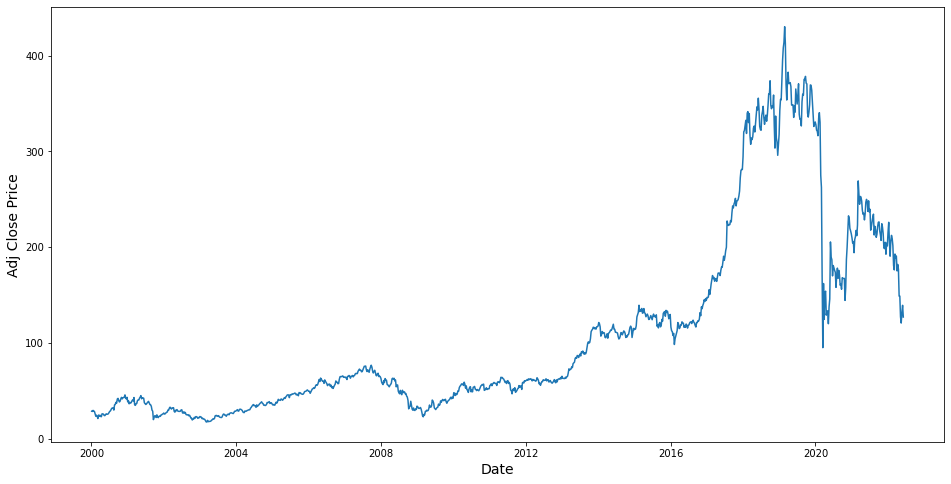

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close Price' ,fontsize=14)
plt.plot(stock_w['Adj Close'])
plt.show()

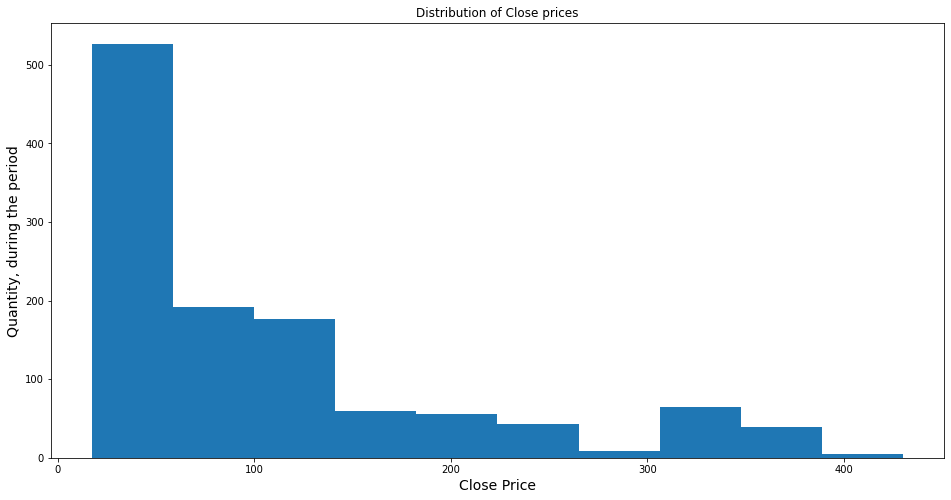

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.hist(stock_w['Adj Close'])
plt.ylabel('Quantity, during the period', fontsize=14)
plt.xlabel('Close Price' ,fontsize=14)
plt.title('Distribution of Close prices')
plt.show()

#### Building the LSTM model

In [34]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [35]:
# create a new data frame with only 'Close column'
data = stock_w.filter(['Adj Close'])
dataset = data.values #convert the data frame to a numpy array
training_data_len = math.ceil(len(dataset)*.8)  # number of rows to train the model on
training_data_len

937

In [36]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02731194],
       [0.02682348],
       [0.02946102],
       ...,
       [0.27823943],
       [0.295238  ],
       [0.26557528]])

In [37]:
#create the training dataset
#create the scaled training dataset

train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train, y_train datasets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.02731194, 0.02682348, 0.02946102, 0.02780035, 0.02682348,
       0.02058966, 0.01451229, 0.01735493, 0.01441426, 0.00882699,
       0.01764899, 0.01451229, 0.01735493, 0.01402218, 0.01353206,
       0.02088372, 0.02029559, 0.02000151, 0.01658862, 0.01619509,
       0.01826109, 0.02081902, 0.01973683, 0.01983521, 0.02081902,
       0.02386883, 0.02691866, 0.02800087, 0.03173936, 0.03488757,
       0.03518274, 0.0363924 , 0.03017639, 0.04349636, 0.04448301,
       0.04981095, 0.04783768, 0.05829626, 0.05987492, 0.05434959,
       0.05079765, 0.05277097, 0.05869092, 0.06234156, 0.05851202,
       0.06147841, 0.06197275, 0.06217054, 0.06869647, 0.06068738,
       0.05841314, 0.06246717, 0.05099726, 0.05396363, 0.04615224,
       0.04990959, 0.04799138, 0.0490392 , 0.05324429, 0.05581493])]
[0.05341879264220231]



In [38]:
#convert the x_train and y_train  to numppy array
x_train,y_train = np.array(x_train), np.array(y_train)

In [39]:
#reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(877, 60, 1)

In [40]:
#Buil the LSTM model
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))

In [41]:
#Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
877/877 [==============================] - 16s 16ms/step - loss: 9.0821e-04
Epoch 2/10
877/877 [==============================] - 13s 15ms/step - loss: 2.8892e-04
Epoch 3/10
877/877 [==============================] - 14s 16ms/step - loss: 3.9186e-04
Epoch 4/10
877/877 [==============================] - 16s 18ms/step - loss: 2.2067e-04
Epoch 5/10
877/877 [==============================] - 15s 17ms/step - loss: 2.3838e-04
Epoch 6/10
877/877 [==============================] - 15s 17ms/step - loss: 1.2869e-04
Epoch 7/10
877/877 [==============================] - 16s 18ms/step - loss: 1.4824e-04
Epoch 8/10
877/877 [==============================] - 16s 18ms/step - loss: 1.4512e-04
Epoch 9/10
877/877 [==============================] - 18s 21ms/step - loss: 2.2107e-04
Epoch 10/10
877/877 [==============================] - 17s 19ms/step - loss: 1.2865e-04


In [43]:
#create the testing data sets
#create a new array containing scale values
test_data= scaled_data[training_data_len-60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [44]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [45]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(234, 60, 1)

In [46]:
#predicting the data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [47]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4.061621608897152

In [ ]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

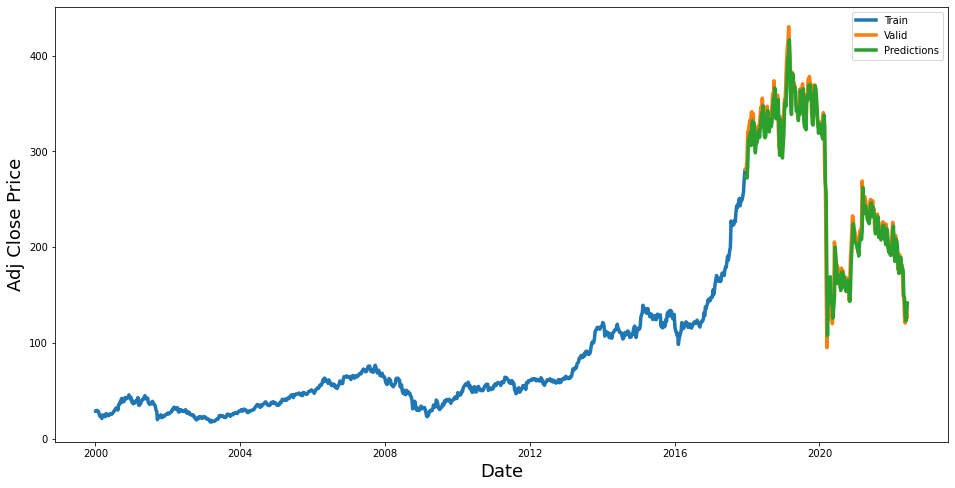

In [49]:
#Visialization the data
plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price' ,fontsize=18)
plt.plot(train['Adj Close'],linewidth=3.5, label = 'Train')
plt.plot(valid['Adj Close'],linewidth=3.5, label = 'Valid')
plt.plot(valid['Predictions'],linewidth=3.5, label = 'Predictions')
plt.legend()
plt.show()

In [50]:
#show the valid and predicted price
valid

,Adj Close,Predictions
Date,,
2017-12-18,281.228241,273.726288
2017-12-25,281.047150,273.595612
2018-01-01,294.322327,272.209290
2018-01-08,320.405731,285.256409
2018-01-15,321.854309,312.414856
...,...,...
2022-05-09,127.199997,146.951401
2022-05-16,120.699997,129.721039
2022-05-23,132.229996,122.896843
